In [1]:
!pip install tensorflow
!pip install keras

!pip install numpy scipy

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image, ImageFilter  
import matplotlib.image as mpimg
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


Using TensorFlow backend.


In [3]:
data = pd.read_csv('pokemon.csv', sep=",")
data.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [4]:
data.shape

(809, 3)

In [5]:
image_data=[]
type_data=[]

#Считываем все картинки из папки и сразу сопоставляем каждой картинке тип покемона
# из таблицы, сохраняем в списках image_data и type_data
for name in data['Name']:
    try:
        img = mpimg.imread("images/images/"+ name +".png")[:, :, :3] # считываем без альфа канала
        
        #Другой вариант
        #img = Image.open("images/images/"+ name +".png").convert('RGB')
        #arr = np.asarray(img, dtype=np.float32) #делаем из картинки многомерный массив
        #arr=arr/255 #приводим к виду от 0 до 1
        
        pokemon_type= data[data['Name'] == name].iloc[0]['Type1']
        image_data.append(img)
        type_data.append(pokemon_type)
    except FileNotFoundError: 
        #print("Файл не найден")
        pass

#Преобразуем в один тензор(многомерный массив)
image_data= np.array(image_data, dtype = np.float32)
print(image_data[1][0].shape)
image_data.shape

(120, 3)


(721, 120, 120, 3)

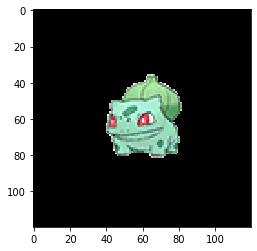

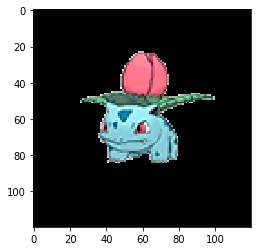

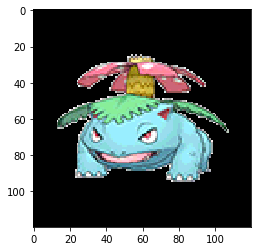

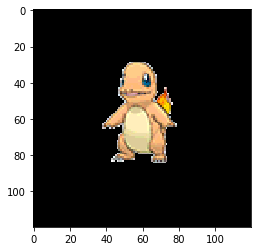

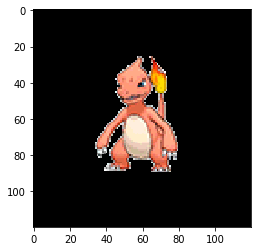

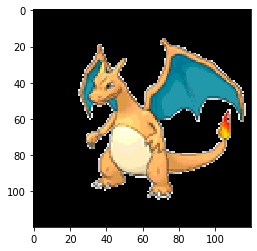

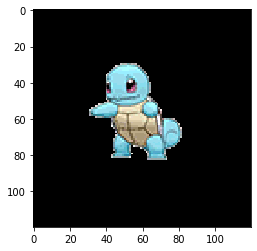

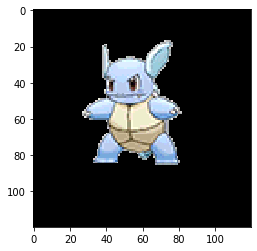

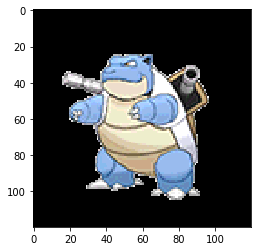

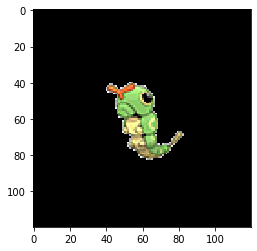

In [6]:
#проверяем что получилось
for i in range(10):
    plt.figure()
    plt.imshow(image_data[i])
    #plt.colorbar()
    plt.grid(False)
    plt.show()

In [7]:
from math import ceil, floor
IMAGE_SIZE = 120

#Функция для сдвига изображения
def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.compat.v1.reset_default_graph()
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), 
            dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
            w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

#Сдвинутые изображения сохраняем в translated_imgs
translated_imgs = translate_images(image_data)
translated_imgs.shape

(2884, 120, 120, 3)

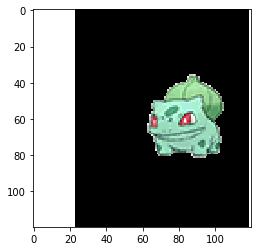

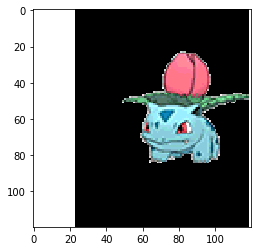

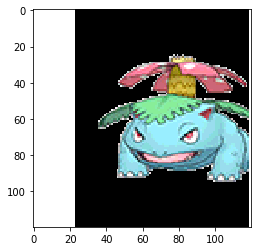

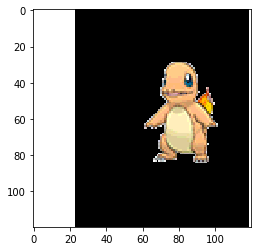

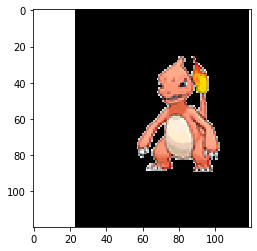

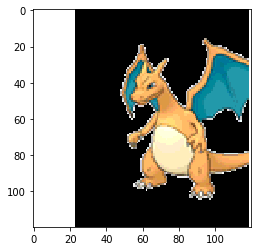

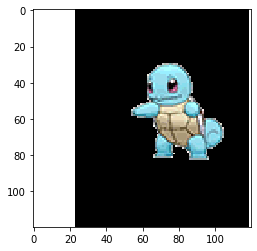

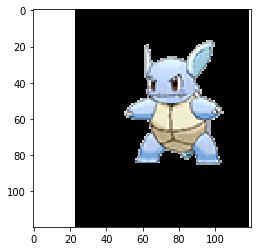

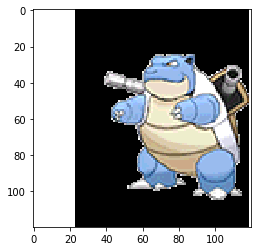

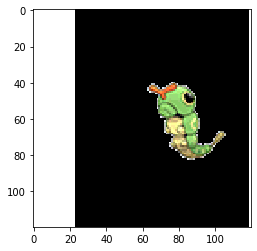

In [8]:
#проверяем что получилось
for i in range(10):
    plt.figure()
    plt.imshow(translated_imgs[i+721])
    #plt.colorbar()
    plt.grid(False)
    plt.show()

In [9]:
#Функция для вращения изображений
def rotate_images(X_imgs):
    X_rotate = []
    a=1
    for i in range(3):  # Rotation at 90, 180 and 270 degrees
        for img in X_imgs:
            rotated_img = tf.image.rot90(img, k=1+i)
            X_rotate.append(rotated_img)
            #print(a)
            a=a+1
        
    #X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

rotated_imgs = rotate_images(image_data)
print(len(rotated_imgs))
rotated_imgs[1].shape

2163


TensorShape([120, 120, 3])

In [10]:
#по какой-то причине не преобразовывалось сразу в массив numpy,
#пришлось делать вручную каждую картинку

rotated_imgs_np=[]
for img in rotated_imgs:
    img_2=img.numpy()
    #print(img_2.shape)
    rotated_imgs_np.append(img_2)
    
rotated_imgs_np=np.array(rotated_imgs_np, dtype=np.float32)
rotated_imgs_np.shape

(2163, 120, 120, 3)

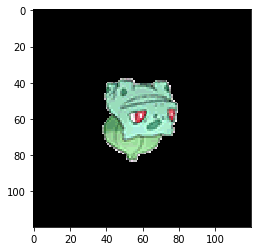

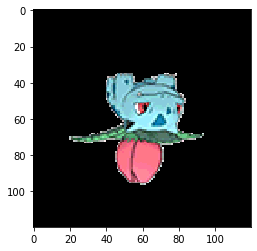

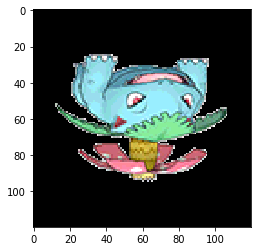

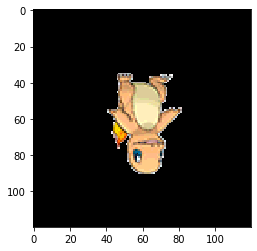

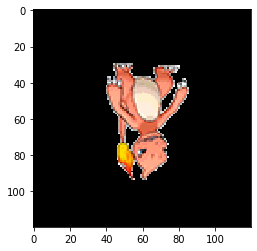

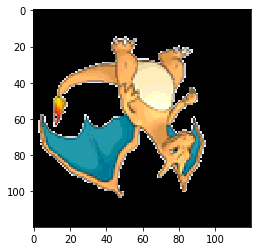

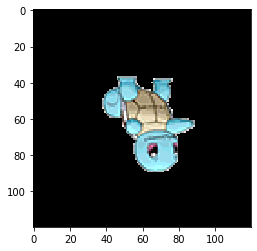

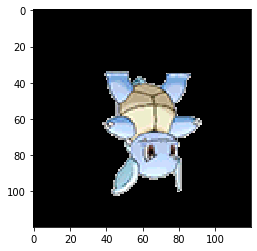

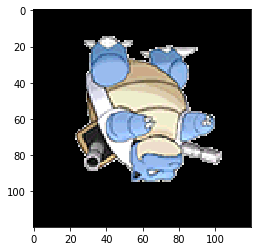

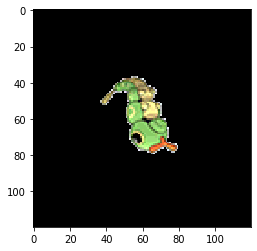

In [11]:
for i in range(10):
    plt.figure()
    plt.imshow(rotated_imgs_np[i+721])
    #plt.colorbar()
    plt.grid(False)
    plt.show()

# Теперь надо объединить все эти изображения, и добавить к ним правильные типы

для этого нужно просто скопировать массив с типами покемонов 8 раз, 4 для смещений, 3 для поворота и оригинальные

In [12]:
#функция совмещения массивов вдоль первой оси(у нас эта ось отвечает за количество изображений)
#повернутые не включаю, с ними получалось хуже
np_image_data=np.vstack((image_data , translated_imgs))
np_type_data=[]


#т.к данных стало в 5 раз больше, то и массив с типами надо увеличить в 5 раз
for i in range(5):
    for pok_type in type_data:
        np_type_data.append(pok_type)
        
np_type_data=np.array(np_type_data)       
        
print(np_image_data.shape)
np_type_data.shape

(3605, 120, 120, 3)


(3605,)

In [13]:
#перемешаем 2 массива вместе(с картинками и типами)
import random

all_mas=[]#массив для изображений и типов вместе
a=0
for i in np_image_data:
    all_mas.append([i, np_type_data[a]])
    a=a+1
    
random.shuffle(all_mas)

np_image_data=[]
np_type_data=[]
for item in all_mas:
    np_image_data.append(item[0])
    np_type_data.append(item[1])

np_image_data=np.array(np_image_data)  
np_type_data=np.array(np_type_data)    
print(np_type_data.shape)   
print(np_image_data.shape)  

(3605,)
(3605, 120, 120, 3)


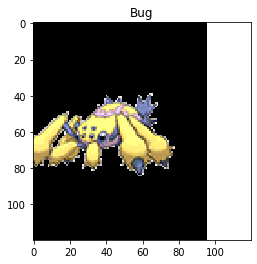

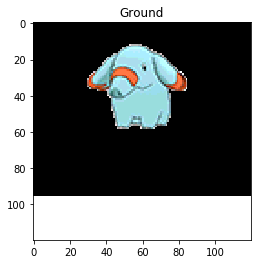

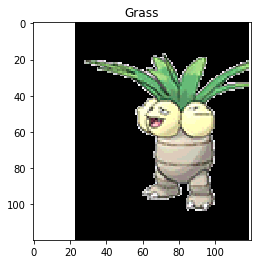

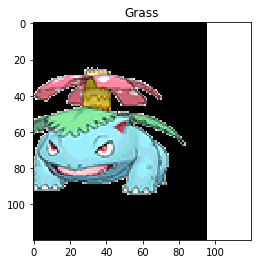

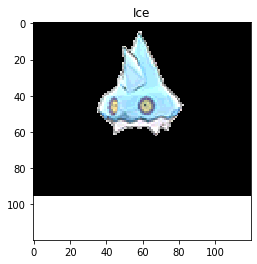

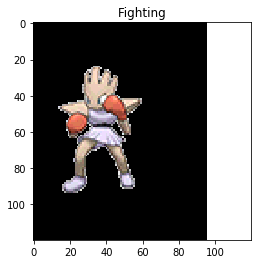

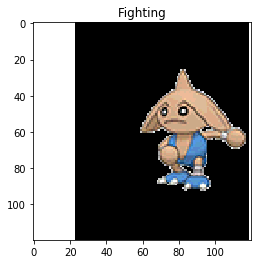

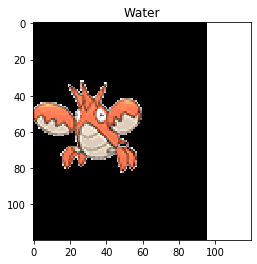

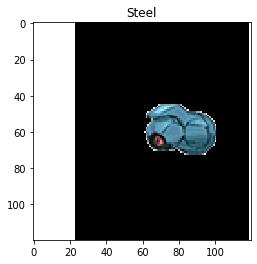

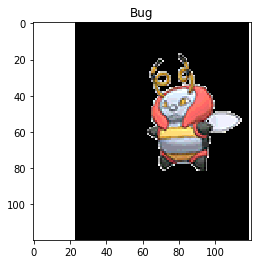

In [14]:
for i in range(10):
    plt.figure()
    plt.imshow(np_image_data[i])
    #plt.colorbar()
    plt.grid(False)
    plt.title(np_type_data[i])
    plt.show()

In [15]:
#преобразуем из типов в список с 0ми и 1цей с помощью OneHotEncoder
ohe = OneHotEncoder()
print(np_type_data.shape)
np_type_data=np_type_data.reshape(-1, 1)
print(np_type_data.shape)
np_type_data_c=ohe.fit_transform(np_type_data)
print(np_type_data_c.shape)

#нормируем
#np_image_data=np_image_data/255


msk = np.random.rand(len(np_image_data)) < 0.9
#разделяем на тестовую и тренировочную
x_train=np_image_data[msk]
x_test=np_image_data[~msk]

y_train=np_type_data_c[msk]
y_test=np_type_data_c[~msk]
y_test.shape

(3605,)
(3605, 1)
(3605, 18)


(342, 18)

In [16]:
batch_size, img_rows, img_cols = 32, 120, 120
input_shape = (img_rows, img_cols, 3)

model = Sequential()
#Convolution2D - сверточный слой, 16-количество каналов, (5, 5)-размер матрицы свертки
model.add(Convolution2D(32, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
#MaxPooling2D - слой субдискретизации, pool_size=(2, 2) - размер, по которому берем максимум(т.е. сохраняем одну из 4 ячеек)
#strides=(2, 2) - шаг, с которым производится дискретизация
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Convolution2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Convolution2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Convolution2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Convolution2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Convolution2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(Convolution2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
#Dropout(0.5) - слой дропаута, выкидываем нейрон из сети при обучении с шансом 0.5, помогает избежать переобучения
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation("softmax"))

In [17]:
model.compile(loss="categorical_crossentropy",
optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=30,
verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Train on 3263 samples, validate on 342 samples
Epoch 1/30
3263/3263 [==============================] - 23s 7ms/step - loss: 2.7325 - accuracy: 0.1318 - val_loss: 2.6947 - val_accuracy: 0.1491
Epoch 2/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.7019 - accuracy: 0.1391 - val_loss: 2.6874 - val_accuracy: 0.1433
Epoch 3/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.6853 - accuracy: 0.1542 - val_loss: 2.6511 - val_accuracy: 0.1520
Epoch 4/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.6053 - accuracy: 0.2004 - val_loss: 2.5526 - val_accuracy: 0.1959
Epoch 5/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.4882 - accuracy: 0.2320 - val_loss: 2.4539 - val_accuracy: 0.2251
Epoch 6/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.4049 - accuracy: 0.2510 - val_loss: 2.4045 - val_accuracy: 0.2690
Epoch 7/30
3263/3263 [==============================] - 22s 7ms/step - loss: 2.2400

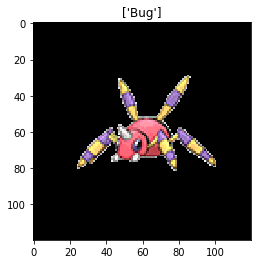

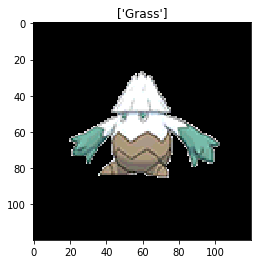

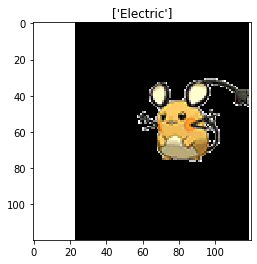

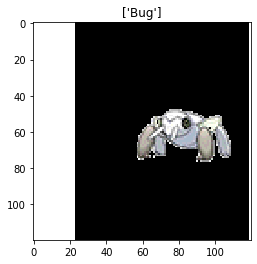

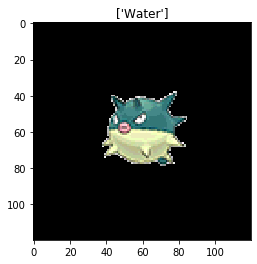

In [22]:
#теперь попробуем предсказать на обученной модели 5 изображений
for i in range(5):
    plt.figure()
    plt.imshow(np_image_data[i+322])
    #plt.colorbar()
    plt.grid(False)
    plt.title(np_type_data[i+322])
    plt.show()

In [24]:
#попробуем использовать обученную сеть для предсказания
#(на вход можно подать любые изображение, главное преобразовать его к нужным размерностям)
#мы проверим на 5 картинках из датасета(322-327 картинки)
model.predict_classes(np_image_data[322:327])

array([ 0,  9,  3,  0, 17], dtype=int64)

In [27]:
#Выводим список, который мы кодировали с помощью OneHotEncoder
ohe.categories_ 

[array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
        'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
        'Psychic', 'Rock', 'Steel', 'Water'], dtype='<U8')]

In [ ]:
#Получается наша сеть дала ответы:
# 0-'Bug'    9-'Grass'  3-'Electric'  0-'Bug'  17-'Water'
#что в данном случае было на 100% правильно